In [1]:
import gym
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

In [2]:
env = gym.make("CartPole-v1", render_mode="rgb_array")

In [3]:
obs, info = env.reset(seed=42)

In [4]:
img = env.render()
img.shape

(400, 600, 3)

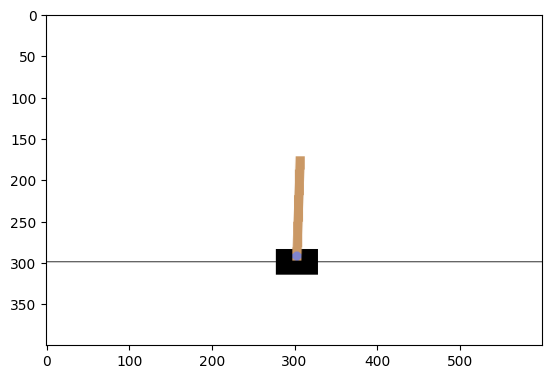

In [5]:
plt.imshow(img)

In [6]:
env.action_space

Discrete(2)

In [7]:
action = 1

In [8]:
obs, reward, done, truncated, info = env.step(action)

c:\Users\kethl\.conda\envs\gym_env\lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


In [9]:
reward

1.0

In [10]:
done

False

In [11]:
truncated

False

In [12]:
info

{}

In [13]:
obs

array([ 0.02727336,  0.18847767,  0.03625453, -0.26141977], dtype=float32)

In [14]:
def basic_policy(obs):
    angle = obs[2]
    return 0 if angle < 0 else 1
totals = []
for episode in range(500):
    episode_rewards = 0
    obs, info = env.reset(seed=episode)
    for step in range(200):
        action = basic_policy(obs)
        obs, reward, done, truncated, info = env.step(action)
        episode_rewards += reward
        if done or truncated:
            break
    totals.append(episode_rewards)

In [15]:
np.mean(totals), np.std(totals), min(totals), max(totals)

(41.698, 8.389445512070509, 24.0, 63.0)

In [16]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(5, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

In [17]:
def play_one_step(env, obs, model, loss_fn):
    with tf.GradientTape() as tape:
        left_proba = model(obs[np.newaxis])
        action = (tf.random.uniform([1, 1]) > left_proba)
        y_target = tf.constant([[1.]]) - tf.cast(action, tf.float32)
        loss = tf.reduce_mean(loss_fn(y_target, left_proba))
        
    grads = tape.gradient(loss, model.trainable_variables)
    obs, reward, done, truncated, info = env.step(int(action))
    return obs, reward, done, truncated, grads

In [18]:
def play_multiple_episodes(env, n_episodes, n_max_steps, model, loss_fn):
    all_rewards = []
    all_grads = []
    for episode in range(n_episodes):
        current_rewards = []
        current_grads = []
        obs, info = env.reset()
        for step in range(n_max_steps):
            obs, reward, done, truncated, grads = play_one_step(env, obs, model, loss_fn)
            current_rewards.append(reward)
            current_grads.append(grads)
            if done or truncated:
                break
        all_rewards.append(current_rewards)
        all_grads.append(current_grads)
    return all_rewards, all_grads

In [19]:
def discount_rewards(rewards, discount_factor):
    discounted = np.array(rewards)
    for step in range(len(rewards) - 2, -1, -1):
        discounted[step] += discounted[step + 1] * discount_factor
    return discounted

In [20]:
def discount_and_normalize_rewards(all_rewards, discount_factor):
    all_discounted_rewards = [discount_rewards(rewards, discount_factor) for rewards in all_rewards]
    flat_rewards = np.concatenate(all_discounted_rewards)
    reward_mean = flat_rewards.mean()
    reward_std = flat_rewards.std()
    return [(discounted_rewards - reward_mean) / reward_std
            for discounted_rewards in all_discounted_rewards]

In [21]:
n_iterations = 150
n_episodes_per_update = 10
n_max_steps = 200
discount_factor = 0.95

In [22]:
optimizer = tf.keras.optimizers.Nadam(learning_rate=0.01)
loss_fn = tf.keras.losses.binary_crossentropy

In [23]:
for iteration in range(n_iterations):
    all_rewards, all_grads = play_multiple_episodes(env, n_episodes_per_update, n_max_steps, model, loss_fn)
    all_final_rewards = discount_and_normalize_rewards(all_rewards,discount_factor)
    all_mean_grads = []
    for var_index in range(len(model.trainable_variables)):
        mean_grads = tf.reduce_mean(
            [final_reward * all_grads[episode_index][step][var_index]
            for episode_index, final_rewards in enumerate(all_final_rewards)
                for step, final_reward in enumerate(final_rewards)], axis=0)
        all_mean_grads.append(mean_grads)
    optimizer.apply_gradients(zip(all_mean_grads, model.trainable_variables))

In [32]:
mean_reward = np.mean([len(r) for r in all_final_rewards])
mean_reward

190.2